In [1]:
import os, sys
os.chdir('../')
sys.argv = ["eval.py", "experiment=final_version", "ckpt_path=pretrain/nyu.ckpt", "num_sample=keypoints_orb", "task_name=final_version_ORB"]

In [2]:
from typing import List, Tuple

import hydra
import pytorch_lightning as pl

from omegaconf import DictConfig
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import Logger
from src import utils

model: LightningModule
datamodule: LightningDataModule
trainer: Trainer

@hydra.main(version_base="1.3", config_path="/data2/wlsgur4011/SparseDC/configs", config_name="eval.yaml")
def load_model(cfg: DictConfig):
    global model, datamodule, trainer
    assert cfg.ckpt_path
    if cfg.get("seed"):
        pl.seed_everything(cfg.seed)
    
    datamodule = hydra.utils.instantiate(cfg.data)

    model = hydra.utils.instantiate(cfg.model)
    logger: List[Logger] = utils.instantiate_loggers(cfg.get("logger"))
    trainer = hydra.utils.instantiate(cfg.trainer, logger=logger)

load_model()

/opt/conda/envs/sparsedc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 2023
/opt/conda/envs/sparsedc/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: pretrain/nyu.ckpt
The model and loaded state dict do not match exactly

unexpected key in source state_dict: net.backbone_l.conv.0.weight, net.backbone_l.conv.1.weight, net.backbone_l.conv.1.bias, net.backbone_l.conv.1.running_mean, net.backbone_l.conv.1.running_var, net.backbone_l.conv.1.num_batches_tracked, net.backbone_l.convs.0.0.conv1.weight, net.backbone_l.convs.0.0.bn1.weight, net.backbone_l.convs.0.0.bn1.bias, net.backbone_l.convs.0.0.bn1.running_mean, net.backbone_l.convs.0.0.bn1.running_var, net.backbone_l.convs.0.0.bn1.num_batches_tracked, net.backbone_l.convs.0.0.conv2.weight, net.backbone_l.convs.0.0.bn2.weight, net.backbone_l.convs.0.0.bn2.bias, net.backbone_l.convs.0.0.bn2.running_mean, net.backbone_l.convs.0.0.bn2.running_var, net.backbone_l.convs.0.0.bn2.num_batches_tracked, net.backbone_l.convs.0.1.conv1.weight, net.backbone_l.convs.0.1.bn1.weight, net.backbone_l.convs.0.1.bn1.bias, net.backbone_l.convs.0.1.bn1.running_mean, net.backbo

/opt/conda/envs/sparsedc/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/envs/sparsedc/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


[2024-01-16 19:02:24,109][src.utils.utils][INFO] - Instantiating logger <pytorch_lightning.loggers.tensorboard.TensorBoardLogger>


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
trainer.test(model=model, datamodule=datamodule, ckpt_path="pretrain/nyu.ckpt")

Missing logger folder: /data2/wlsgur4011/SparseDC/logs/nyu/Uncertainty/eval/final_version_ORB/2024-01-16_19-01-31/tensorboard/
Restoring states from the checkpoint path at pretrain/nyu.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loaded model weights from checkpoint at pretrain/nyu.ckpt
/opt/conda/envs/sparsedc/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:  16%|█▌        | 103/654 [00:25<02:15,  4.08it/s]

/opt/conda/envs/sparsedc/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [57]:
model.cuda()
import torch
# data = torch.load("tmp_data/0.batch.pth")
data = torch.load("/data2/wlsgur4011/DDGS/tmp_data/input.pt")
from jhutil import to_cuda
data = to_cuda(data)

scale = 0.5
data["dep"] = data["dep"] * scale
with torch.no_grad():
    pred, _, _ = model.forward(data)

In [58]:

import jhutil; jhutil.jhprint(1111, data)

1111  {
    "rgb": "tensor[1, 3, 228, 304] n=207936 (0.8Mb) x∈[-1.998, 2.640] μ=-0.113 σ=0.984 cuda:0",
    "dep": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[0., 7.763] μ=0.136 σ=0.489 cuda:0"
}


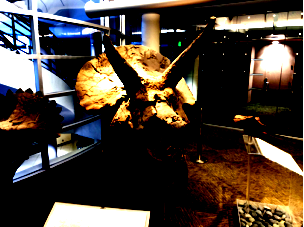

In [59]:
data['rgb'][0].rgb

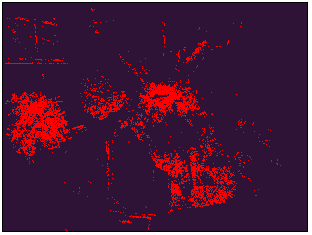

In [60]:
(data['dep'][0] * 100).chans

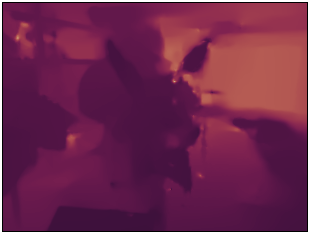

In [61]:
(pred[0] / 20 / scale).chans

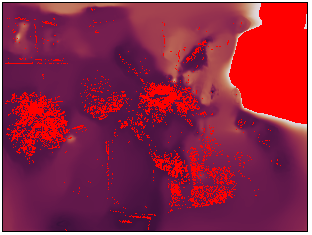

In [50]:
(pred[0] / 20 / scale + data['dep'][0] * 100).chans